In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import math
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [104]:
df = pd.read_csv('drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [106]:
df.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

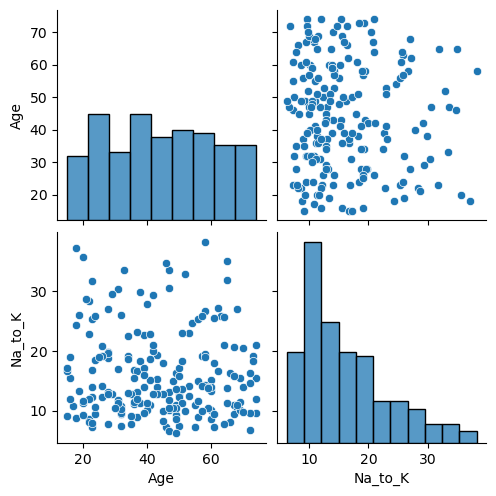

In [107]:
sns.pairplot(df)
plt.show()

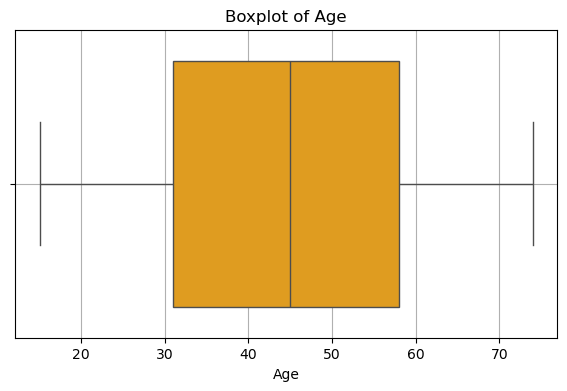

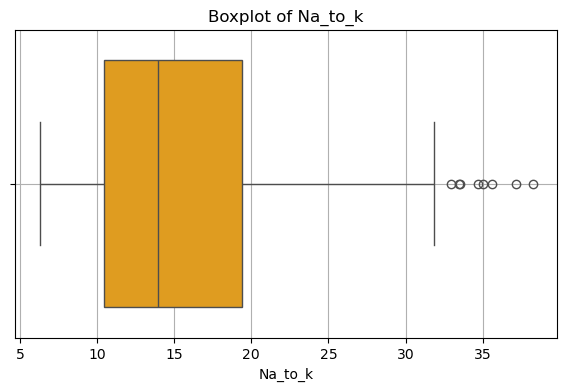

In [108]:
features = ['Age','Na_to_K']

for feature in features:
    plt.figure(figsize=(7, 4))
    sns.boxplot(x=df[feature], color='orange')
    plt.title(f"Boxplot of {feature.capitalize()}")
    plt.xlabel(feature.capitalize())
    plt.grid(True)
    plt.show()

In [109]:
df_original = df.copy()  # Save original before outlier removal


In [110]:
def remove_outliers_zscore(df, cols, threshold=1.75 , target_col='Drug'):
    frames = []

    for class_val in df[target_col].unique():
        class_df = df[df[target_col] == class_val].copy()
        zscores = np.abs(zscore(class_df[cols]))

        # Keep only rows with all z-scores < threshold
        mask = (zscores < threshold).all(axis=1)
        class_df = class_df[mask]
        frames.append(class_df)

    return pd.concat(frames, axis=0).reset_index(drop=True)

In [111]:
df_z_cleaned = remove_outliers_zscore(df, ['Na_to_K'])

In [112]:
print("Shape after outlier removal:", df_z_cleaned.shape)
print(df_z_cleaned.head())

Shape after outlier removal: (187, 6)
   Age Sex      BP Cholesterol  Na_to_K   Drug
0   23   F    HIGH        HIGH   25.355  drugY
1   61   F     LOW        HIGH   18.043  drugY
2   49   F  NORMAL        HIGH   16.275  drugY
3   60   M  NORMAL        HIGH   15.171  drugY
4   43   M     LOW      NORMAL   19.368  drugY


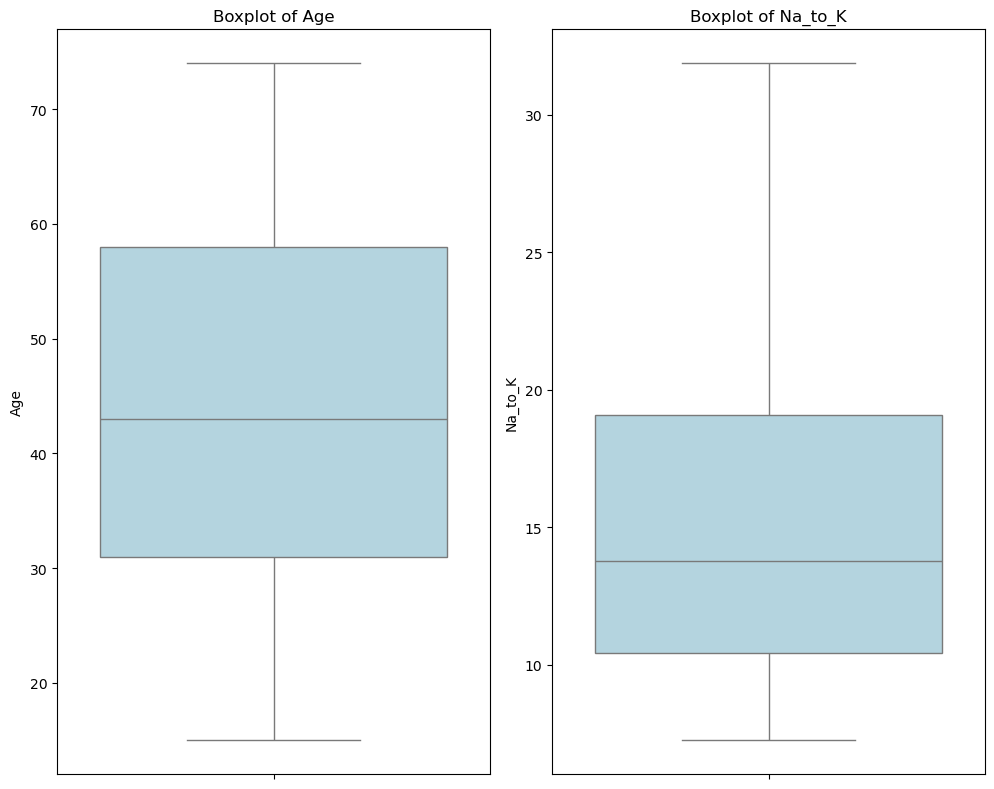

In [113]:
numeric_cols = df_z_cleaned.select_dtypes(include='number').columns.tolist()

plt.figure(figsize=(15, 8))
n_cols = 3
n_rows = math.ceil(len(numeric_cols) / n_cols)

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=df_z_cleaned[col], color='lightblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()


In [114]:
df = df.copy()

# 1. Encode categorical features
df_encoded_z_cleaned = pd.get_dummies(df_z_cleaned, columns=['Sex', 'BP', 'Cholesterol'], drop_first=True)

# 2. Encode the target label
le = LabelEncoder()
df_encoded_z_cleaned['Drug'] = le.fit_transform(df_encoded_z_cleaned['Drug'])


In [115]:
!pip install graphviz


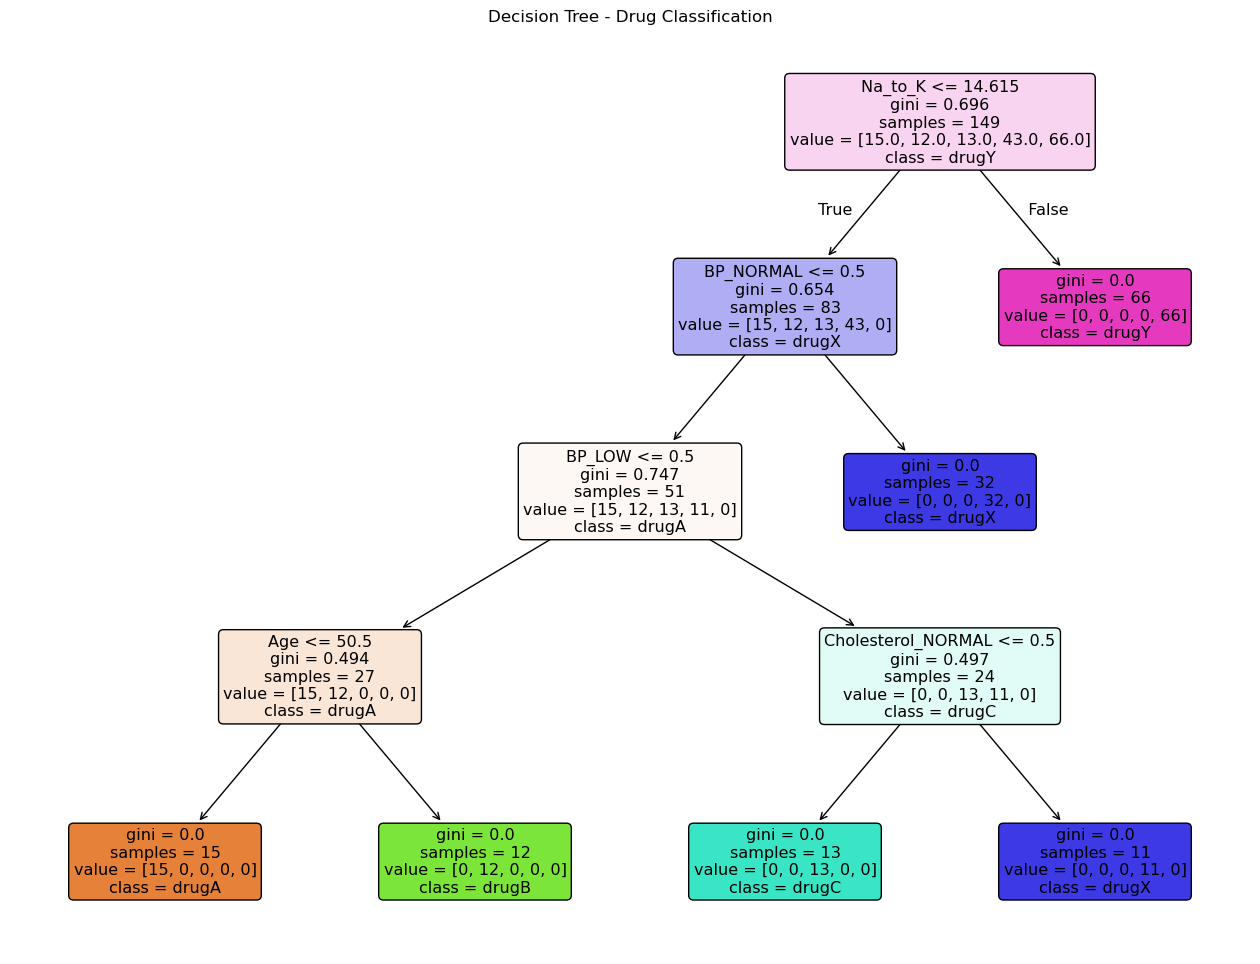

In [116]:
# 3. Split features and target
X = df_encoded_z_cleaned.drop('Drug', axis=1)
y = df_encoded_z_cleaned['Drug']

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. Train the Decision Tree model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# 6. Visualize the Decision Tree
plt.figure(figsize=(16, 12))
plot_tree(clf, feature_names=X.columns, class_names=le.classes_, filled=True, rounded=True)
plt.title("Decision Tree - Drug Classification")
plt.show()


In [117]:
print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)


Train shape: (149, 6)
Test shape : (38, 6)


In [118]:
clf_default = DecisionTreeClassifier(random_state=42)
clf_default.fit(X_train, y_train)

# Training and test accuracy
train_acc = clf_default.score(X_train, y_train)
test_acc = clf_default.score(X_test, y_test)

print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)


Training Accuracy: 1.0
Test Accuracy: 1.0


In [119]:
# Try limiting max_depth
clf_pruned = DecisionTreeClassifier(max_depth=3, random_state=42)
clf_pruned.fit(X_train, y_train)

train_acc_pruned = clf_pruned.score(X_train, y_train)
test_acc_pruned = clf_pruned.score(X_test, y_test)

print("Pruned Tree - Training Accuracy:", train_acc_pruned)
print("Pruned Tree - Test Accuracy:", test_acc_pruned)


Pruned Tree - Training Accuracy: 0.8456375838926175
Pruned Tree - Test Accuracy: 0.7368421052631579


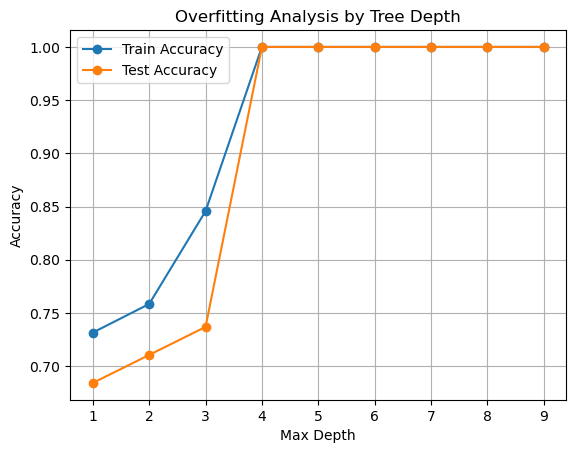

In [120]:
depths = range(1, 10)
train_scores = []
test_scores = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))  # ✅ fixed line

plt.plot(depths, train_scores, label='Train Accuracy', marker='o')
plt.plot(depths, test_scores, label='Test Accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Overfitting Analysis by Tree Depth')
plt.legend()
plt.grid(True)
plt.show()


In [121]:
optimal_depth = depths[np.argmax(test_scores)]
print("Optimal max_depth:", best_depth)


Optimal max_depth: 4


In [122]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

rf_train_acc = rf_clf.score(X_train, y_train)
rf_test_acc = rf_clf.score(X_test, y_test)

print("Random Forest Training Accuracy:", rf_train_acc)
print("Random Forest Test Accuracy:", rf_test_acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=le.classes_))


Random Forest Training Accuracy: 1.0
Random Forest Test Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

       drugA       1.00      1.00      1.00         7
       drugB       1.00      1.00      1.00         4
       drugC       1.00      1.00      1.00         1
       drugX       1.00      1.00      1.00         9
       drugY       1.00      1.00      1.00        17

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



In [123]:
dt_train_acc = clf.score(X_train, y_train)
dt_test_acc = clf.score(X_test, y_test)

print("Decision Tree Training Accuracy:", dt_train_acc)
print("Decision Tree Test Accuracy:", dt_test_acc)


Decision Tree Training Accuracy: 1.0
Decision Tree Test Accuracy: 1.0


In [124]:
print(f"Decision Tree: Train = {dt_train_acc:.2f}, Test = {dt_test_acc:.2f}")
print(f"Random Forest: Train = {rf_train_acc:.2f}, Test = {rf_test_acc:.2f}")


Decision Tree: Train = 1.00, Test = 1.00
Random Forest: Train = 1.00, Test = 1.00


In [125]:
print("Test set size:", len(X_test))


Test set size: 38


In [126]:
# Decision Tree
dt_scores = cross_val_score(DecisionTreeClassifier(random_state=42), X, y, cv=5)
print("Decision Tree 5-Fold Accuracy:", dt_scores)
print("Mean:", dt_scores.mean())

# Random Forest
rf_scores = cross_val_score(RandomForestClassifier(random_state=42), X, y, cv=5)
print("Random Forest 5-Fold Accuracy:", rf_scores)
print("Mean:", rf_scores.mean())


Decision Tree 5-Fold Accuracy: [1.         1.         1.         0.97297297 1.        ]
Mean: 0.9945945945945945
Random Forest 5-Fold Accuracy: [1.         1.         1.         0.97297297 1.        ]
Mean: 0.9945945945945945


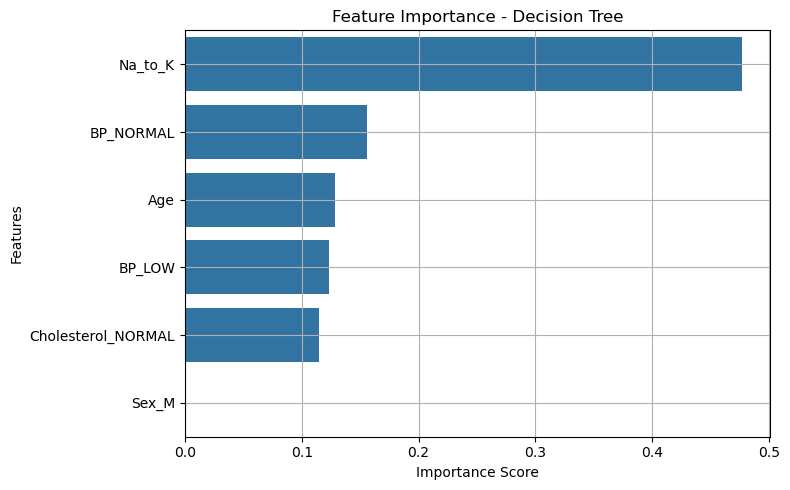

In [127]:
# clf = DecisionTreeClassifier(...).fit(X_train, y_train)

dt_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
dt_importances = dt_importances.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=dt_importances.values, y=dt_importances.index)
plt.title("Feature Importance - Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(True)
plt.tight_layout()
plt.show()


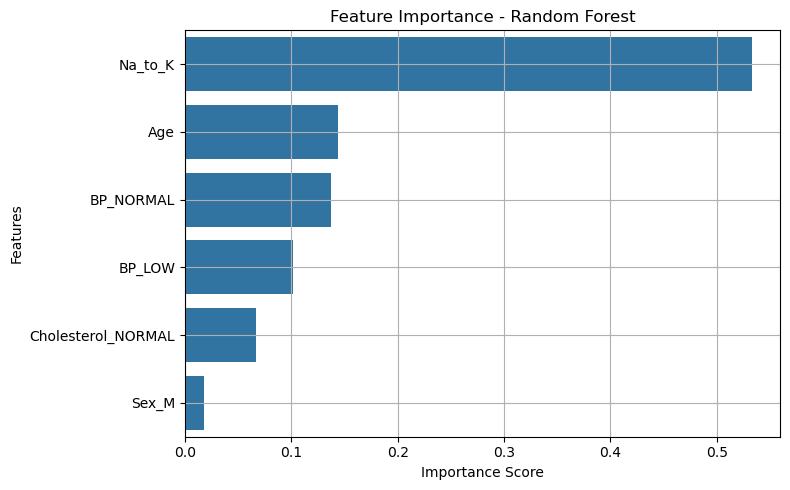

In [128]:
# Assuming: rf_clf = RandomForestClassifier(...).fit(X_train, y_train)

rf_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
rf_importances = rf_importances.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=rf_importances.values, y=rf_importances.index)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(True)
plt.tight_layout()
plt.show()


In [129]:
clf = DecisionTreeClassifier(max_depth=optimal_depth, random_state=42)  # or just use max_depth=None
dt_scores = cross_val_score(clf, X, y, cv=5)

print("Decision Tree CV Scores:", dt_scores)
print("Decision Tree Mean Accuracy:", dt_scores.mean())


Decision Tree CV Scores: [1.         1.         1.         0.97297297 1.        ]
Decision Tree Mean Accuracy: 0.9945945945945945


In [130]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf_clf, X, y, cv=5)

print("Random Forest CV Scores:", rf_scores)
print("Random Forest Mean Accuracy:", rf_scores.mean())


Random Forest CV Scores: [1.         1.         1.         0.97297297 1.        ]
Random Forest Mean Accuracy: 0.9945945945945945
